In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [2]:
from AE import train_AE, AE

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = torchvision.datasets.MNIST(
    root="mnist/",
    train=True,
    download=True,
    transform=transform
)

In [4]:
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([7, 2, 6, 8, 6, 9, 7, 9])


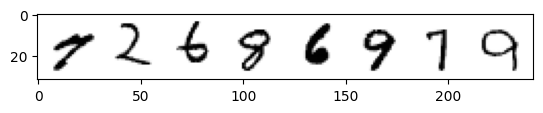

In [5]:
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys');

In [6]:
input_origin_size = 28*28
hidden_dim = 32
mlp_size = 128
n_tokens = 8

In [7]:
model_AE = AE(input_origin_size, hidden_dim, mlp_size)

In [8]:
train_dataloader = DataLoader(dataset, batch_size=99999999, shuffle=True)

In [9]:
train_AE(model_AE, 100, train_dataloader, lr=3e-3)

epoch 1/100 done - avg loss=0.6956
epoch 2/100 done - avg loss=0.6549
epoch 3/100 done - avg loss=0.6482
epoch 4/100 done - avg loss=0.5892
epoch 5/100 done - avg loss=0.5590
epoch 6/100 done - avg loss=0.5063
epoch 7/100 done - avg loss=0.4519
epoch 8/100 done - avg loss=0.4133
epoch 9/100 done - avg loss=0.3803
epoch 10/100 done - avg loss=0.3475
epoch 11/100 done - avg loss=0.3219
epoch 12/100 done - avg loss=0.3042
epoch 13/100 done - avg loss=0.2918
epoch 14/100 done - avg loss=0.2832
epoch 15/100 done - avg loss=0.2777
epoch 16/100 done - avg loss=0.2734
epoch 17/100 done - avg loss=0.2697
epoch 18/100 done - avg loss=0.2670
epoch 19/100 done - avg loss=0.2649
epoch 20/100 done - avg loss=0.2634
epoch 21/100 done - avg loss=0.2623
epoch 22/100 done - avg loss=0.2613
epoch 23/100 done - avg loss=0.2601
epoch 24/100 done - avg loss=0.2589
epoch 25/100 done - avg loss=0.2575
epoch 26/100 done - avg loss=0.2560
epoch 27/100 done - avg loss=0.2549
epoch 28/100 done - avg loss=0.2538
e

In [11]:
from diffusion import train_diffusion, DiffusionNet

In [18]:
diff_model = DiffusionNet(128, n_layers=3, n_heads=4, dropout_rate=0.05, mlp_size=mlp_size, T=20)

In [ ]:
train_diffusion(diff_model, model_AE, 100, train_dataloader, 20, 1e-3)